# SIMPLE WORKING VERSION

# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [9]:
train_len = 30000
test_len = 3000

In [10]:
train_df = sample_df_num(train_df, train_len)

In [11]:
test_df = sample_df_num(test_df, test_len)

In [12]:
#train_df = sample_df_perc(train_df, 1)

In [12]:
train_df.shape, test_df.shape

((30000, 2), (3000, 2))

In [13]:
train_df.head(3)

,Question,Answer
0,"After Morsi removal, what country has Egypt im...",Russia
1,"According to Baptists, who should have baptisms?",professing believers
2,What is a tradition unique to the Creole people?,touloulous


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [14]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

Besides Melanesia, which country sent many workers for the cocoa and rubber plantations in Samoa?
['besides', 'melanesia', 'which', 'country', 'sent', 'many', 'workers', 'cocoa', 'rubber', 'plantations', 'samoa']
['besid', 'melanesia', 'which', 'countri', 'sent', 'mani', 'worker', 'cocoa', 'rubber', 'plantat', 'samoa']


In [15]:
from modules.vocab import Vocab

In [16]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [17]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [18]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
23335,Rayon comes from what plant product?,cellulose,"[rayon, come, what, plant, product]",[cellulose]
19361,Who was the ruler of the underworld in ancient...,Osiris,"[who, ruler, underworld, ancient, egypt]",[osiris]
15718,"What are people being trained for, mainly, in ...",trades,"[what, peopl, train, main, pakistan, polytechn...",[trades]


In [19]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [20]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [21]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [22]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [23]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [24]:
Q_vocab.n_words, A_vocab.n_words, 

(17174, 22299)

In [25]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [26]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(18184, 23669)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [27]:
from modules.stats import sentences_stats, histograms

In [28]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.44
	         median: 6.00
	         minimum: 1
	         maximum: 32)
Sentences in column Answer_tokens:
	         mean: 2.42
	         median: 2.00
	         minimum: 0
	         maximum: 20)


In [29]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.52
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.33
	         median: 2.00
	         minimum: 0
	         maximum: 15)


### Remove the least common words from the sentences

In [30]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [31]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 9111 words that occur only once, answers vocabulary has 14156 such words


### Create lists of those words and remove them from the sequences

In [32]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [33]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [34]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [35]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.17
	         median: 6.00
	         minimum: 0
	         maximum: 29)
Sentences in column Answer_tokens:
	         mean: 1.98
	         median: 2.00
	         minimum: 0
	         maximum: 19)


In [36]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.25
	         median: 6.00
	         minimum: 1
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 1.93
	         median: 2.00
	         minimum: 0
	         maximum: 13)


### Remove questions that have less than three words and answers that have less than one

In [37]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


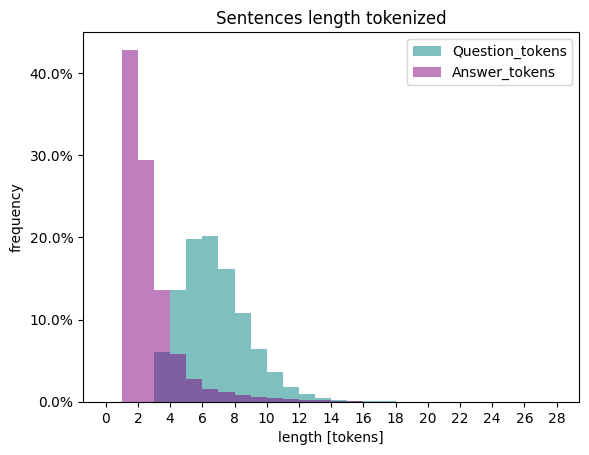

In [38]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [39]:
train_df_final.shape

(25774, 4)

In [40]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.27
	         median: 6.00
	         minimum: 3
	         maximum: 29)
Sentences in column Answer_tokens:
	         mean: 2.25
	         median: 2.00
	         minimum: 1
	         maximum: 19)


In [41]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


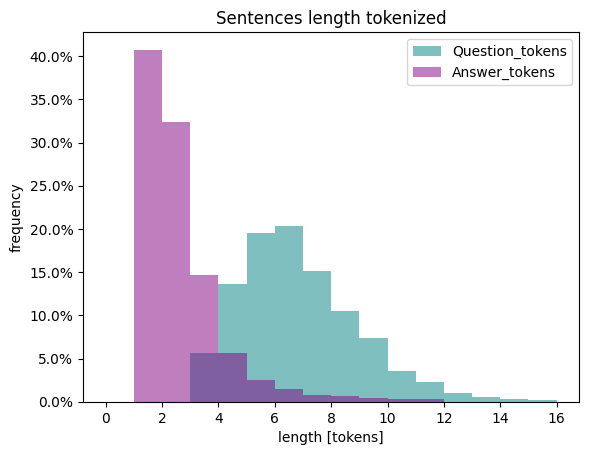

In [42]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [43]:
test_df_final.shape

(2596, 4)

In [44]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.34
	         median: 6.00
	         minimum: 3
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.16
	         median: 2.00
	         minimum: 1
	         maximum: 13)


### Remove long outliers: long sentences that occure rarely

In [45]:
# keeping only the 95% of the data
cutoff = 95

In [46]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [47]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [48]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [49]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.08
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.97
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [50]:
# to simplify I'm using the same thresholds for the test set

In [50]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [51]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.12
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.99
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [52]:
train_df_final.shape, test_df_final.shape

((23880, 4), (2419, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [53]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [54]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [55]:
len(train_pairs_final), len(test_pairs_final)

(23880, 2419)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



# BACK TO SIMPLE MODEL

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)

        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        
        x = x.view(1, 1, -1)
        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state
    
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
                
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        max_len, batch_size = trg_batch.shape
        #batch_size, max_len = trg_batch.shape
        
        # print(f'Seq len: {max_len}, batch size {batch_size}, src_batch {src_batch.shape}, trg_batch {trg_batch.shape}')
                
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        
        
        trg = trg_batch[0]
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

In [107]:
import torch
import torch.nn as nn

## ENCODER

In [108]:
class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        # embedding step
        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)        
        x = x.view(1, 1, -1)        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

## DECODER

In [109]:
class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        # embedding
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # fully connected linear layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        # softmax
        self.softmax = nn.LogSoftmax(dim=1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

## SEQ2SEQ

In [156]:
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        # make encoder and decoder 
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
                
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        # target batch (answers) is unpacked to maximum length and batch size
        max_len, batch_size = trg_batch.shape               
        
        #print(f'Seq len: {max_len}, batch size {batch_size}, src_batch {src_batch.shape}, trg_batch {trg_batch.shape}')

        # WHAT IS THE DIFFERENCE BETWEEN max_len and trg_len here???
        
        trg_vocab_size = self.decoder.output_size
        
        # print(f"trg_vocab_size: {trg_vocab_size}")
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

        # print(f"outputs size (tensor to store decoder's outputs): {outputs.shape}")
              
         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        
        # iterate over the length of the source (question sequence) using the encoder
        
        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            
            # src_batch[i] is the ith token of the input (question)
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        # trg_batch[0] that's just the first element of trg_batch        
        trg = trg_batch[0]
        
        
        # now iterating over the target length, using the decoder
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            
            # here we use the teacher forcing: if the random value is less than the ratio, then the target is just an element of the target (token from the answer)
            # otherwise it's the highest probability prediction
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

Seq len: 8, batch size 1, src_batch torch.Size([12, 1]), trg_batch torch.Size([8, 1])
trg_vocab_size: 23669
outputs size (tensor to store decoder's outputs): torch.Size([8, 1, 23669])

### Model parameters

In [157]:
embedding_dim = 256
hidden_size = 256
#dropout = 0.5

### Hyperparameters

In [158]:
learning_rate = 0.01
num_epochs = 5

### Model

In [159]:
#seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, dropout=dropout, device=device)
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [160]:
seq2seq = seq2seq.to(device)

### Optimizer and loss function

In [161]:
from torch import optim
import torch.nn as nn

In [162]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [163]:
total_train_loss = []
total_test_loss = []

# TRYING WITH A DIFFERENT ORDER IN THE SEQUENCE: PADDING AT THE END

In [164]:
def to_tensor(vocab, tokens, seq_len, device):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    If too short, it uses padding at the END of the sentence'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    padded = [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens)) 
    
    tensor = torch.Tensor(padded).long().to(device).view(-1,1)
    
    return tensor

In [165]:
def train(model, pairs, optimizer, criterion, device, teacher_forcing_ratio = 0.5, print_every = 1000): 
    
    model.train() # Set the model to training mode

    total_loss = 0

    count = 0

    for pair in pairs:

        src = pair.question
        tgt = pair.answer

        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=teacher_forcing_ratio)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1 

        if count % print_every == 0:
            print(f'Loss {total_loss/count}')

    return total_loss / len(pairs)

In [166]:
def evaluate(model, pairs, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for pair in pairs:
            
            src = pair.question
            tgt = pair.answer
            
            src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
            tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

            
            total_loss += loss.item()
        
    return total_loss / len(pairs)

In [167]:
import matplotlib.pyplot as plt

In [154]:
# trying with teacher forcing ratio 0.5

In [168]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_pairs_final, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



Loss 5.81101585483551
Loss 5.393553529381752
Loss 5.205246184269587
Loss 5.11162381786108
Loss 5.046745337581634
Loss 4.99920071486632
Loss 4.9536682791199
Loss 4.922924980893731
Loss 4.890773516456286
Loss 4.858674717569351
Loss 4.827493909228932
Loss 4.806599847108125
Loss 4.787198302149773
Loss 4.770445032741343
Loss 4.752787536342939
Loss 4.733679495155811
Loss 4.71724648351529
Loss 4.701130105124579
Loss 4.689200359068419
Loss 4.678317657363415
Loss 4.665387360481989
Loss 4.655418203706091
Loss 4.64594363967232
Epoch 1/5, Train Loss: 4.6354, Test Loss: 4.5639
Loss 4.403522748351097
Loss 4.410748579084873
Loss 4.388168964425723
Loss 4.386690726429224
Loss 4.3862416932582855
Loss 4.389154132942359
Loss 4.384588081053325
Loss 4.3906163081228735
Loss 4.3886343892415365
Loss 4.383702127218246
Loss 4.376403437018395
Loss 4.376819997111956
Loss 4.377143263312487
Loss 4.3781759120225905
Loss 4.376098055203756
Loss 4.3713456773608925
Loss 4.368161561587278
Loss 4.363628509793017
Loss 4.363

In [169]:
N_EPOCHS = 5

Text(0, 0.5, 'loss')

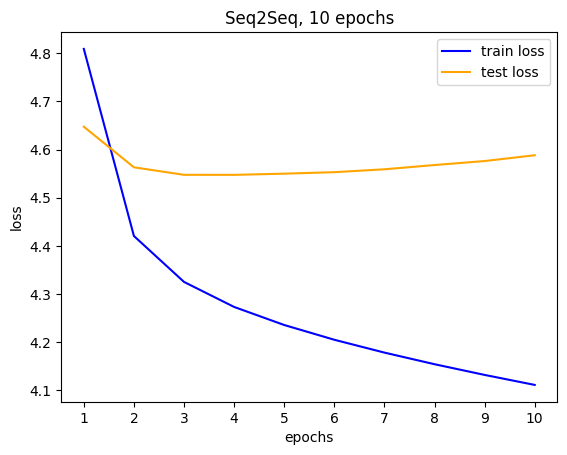

In [99]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

## lower teacher forcing

Text(0, 0.5, 'loss')

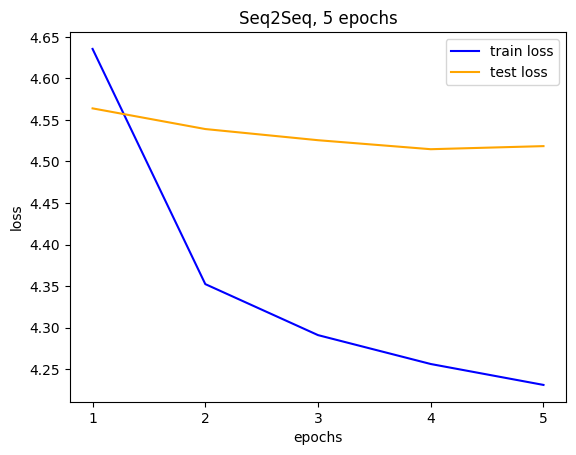

In [170]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

# CURRENT MODEL DOES NOT CONVERGE
# BUT WITH PADDING AT THE END AT LEAST THE TEST LOSS DOES NOT INCREASE... WHY?